# ResNet32 on CIFAR-10

* `architecture : `
    * CIFAR-10 dataset, which consists of 50k training images and 10k testing images in 10 classes.
    * The network inputs are 32 x 32 images, with the per-pixel mean substracted.
    * feature map sizes {32, 16, 8} respectively, wit 2n layers for each feature map size.
    * The numbers of filters are {16, 32, 64} respectively.
    * The subsampling is performed by convolutions with a stride od 2.
    * The network ends with a GAP(Global Average Pooling), a 10-way fc layer, and softmax.
    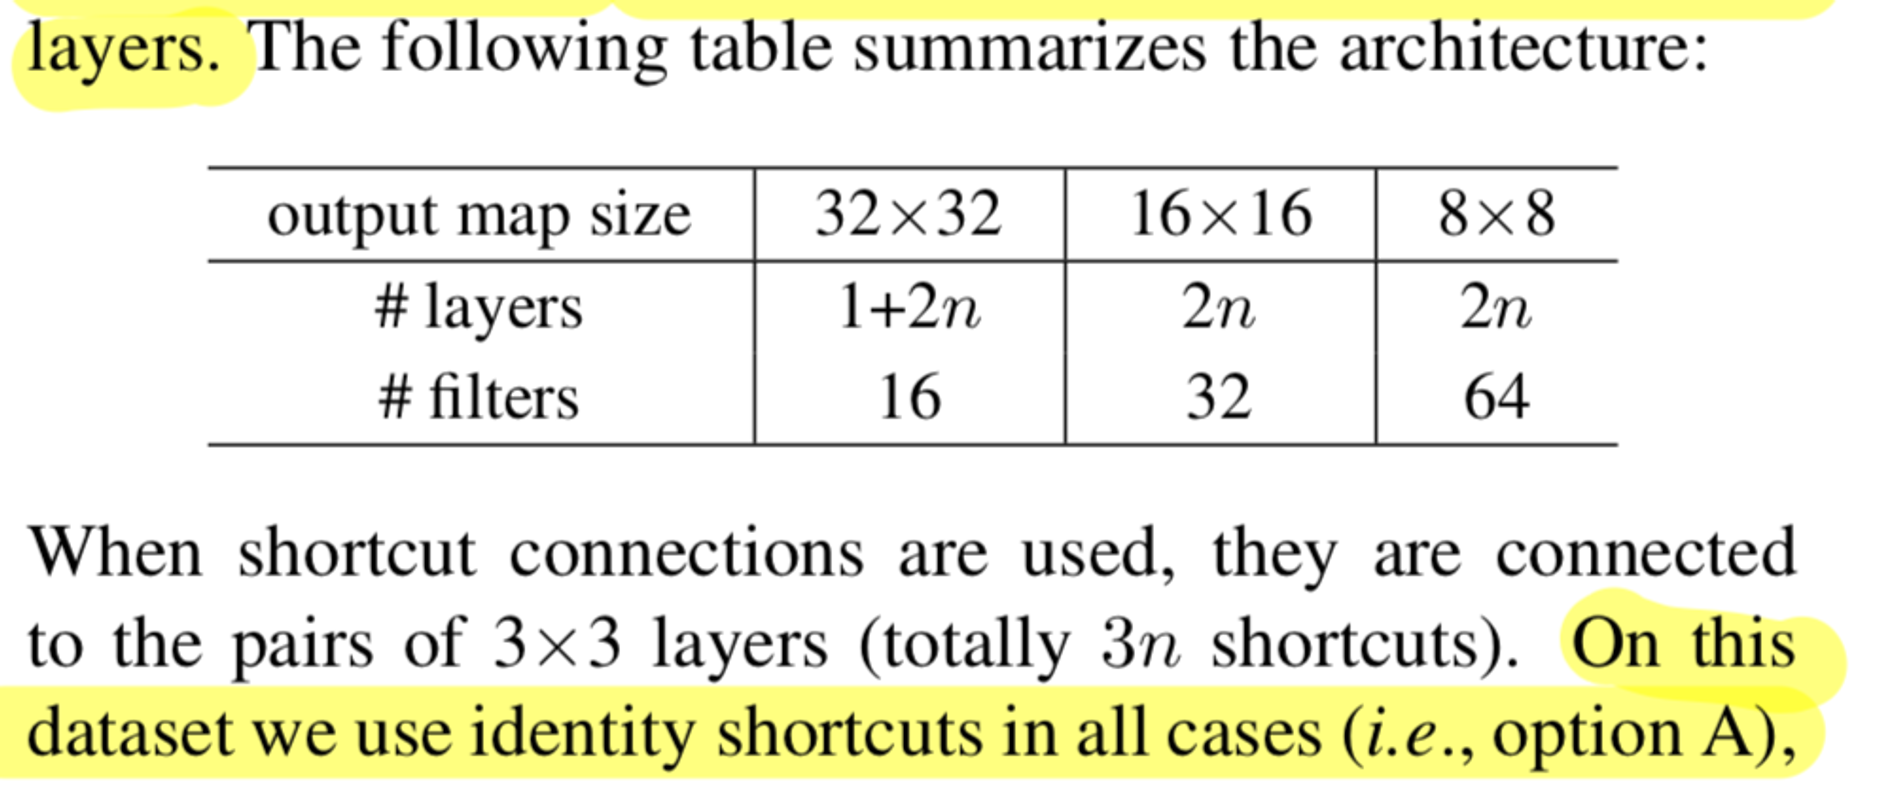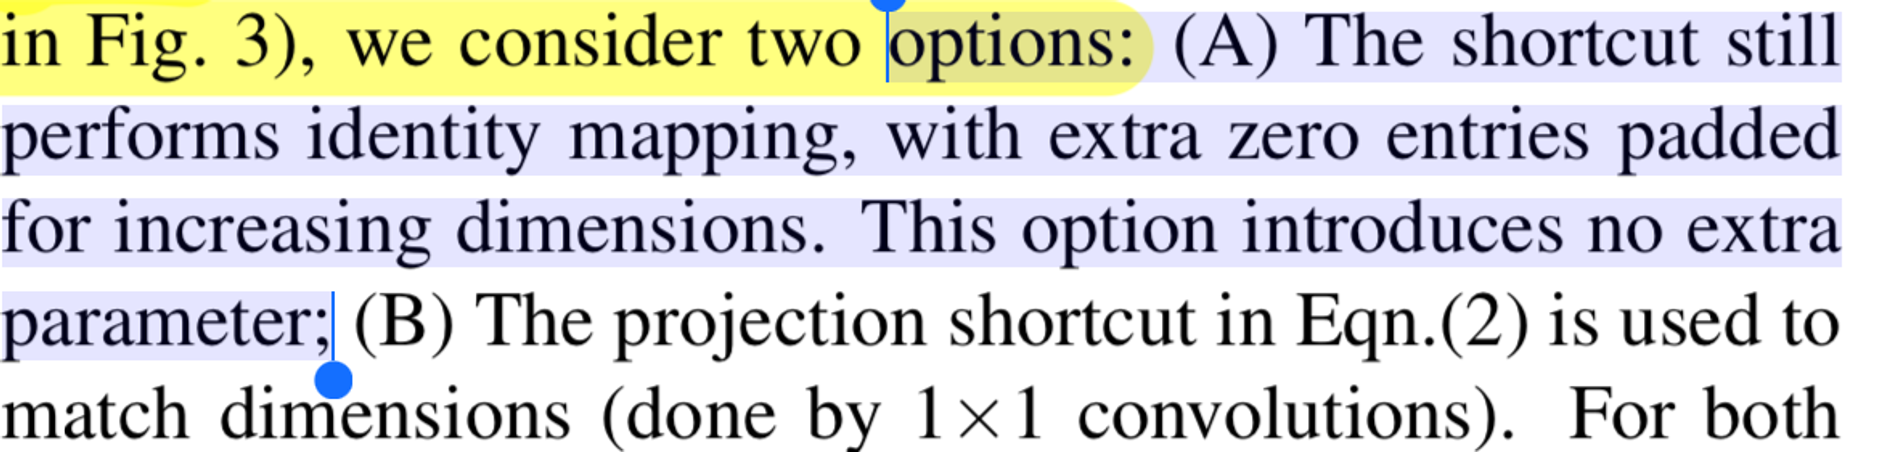

* `training details` : 
    * weight decay : 0.0001
    * momentum : 0.9
    * weight initialization 
    * BN with no dropout
    * a mini-batch size of 128 on two GPUs, which is determined on a 45k/5k train/val split.
    * data augmentation in for training : 4 pixels are padded on each side, and a 32 x 32 crop is randomly sampled from the padded image or its horizontal flip.
    * data augmentation in for testing : only evaluate the single view of the original 32 x 32 image.


In [1]:
import torch
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL

import numpy as np

2024-01-18 07:14:16.788885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 07:14:16.843233: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#  CIFAR-10 dataset, which consists of 50k training images and 10k testing images in 10 classes.
# The network inputs are 32 x 32 images, with the per-pixel mean substracted.

# Load and normalizing the CIFAR10 training and test datasets using torchvision
trainset = torchvision.datasets.CIFAR10(
    root='/home/hslee/Desktop/Datasets', train=True, download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.49139968, 0.48215827 ,0.44653124],
                                std=[0.24703233, 0.24348505, 0.26158768])
    ])    
)

valset = torchvision.datasets.CIFAR10(
    root='/home/hslee/Desktop/Datasets', train=False, download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.49139968, 0.48215827 ,0.44653124],
                            std=[0.24703233, 0.24348505, 0.26158768])

    ])
)

# mini_batch_size = 128
mini_batch_size = 256

Files already downloaded and verified
Files already downloaded and verified


In [3]:

# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=trainset, batch_size=mini_batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=valset, batch_size=mini_batch_size, shuffle=False
)

In [4]:
# check the number of train data, validation data, test data

print('# train datas : ', len(trainset))
print('# validation datas : ', len(valset))

num_train_batch = len(trainset) // mini_batch_size
num_val_batch = len(valset) // mini_batch_size

print('# train batch : ', num_train_batch)
print('# validation batch : ', num_val_batch)

# train datas :  50000
# validation datas :  10000
# train batch :  195
# validation batch :  39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image batch dimensions :  torch.Size([256, 3, 32, 32])
image label dimensions :  torch.Size([256])


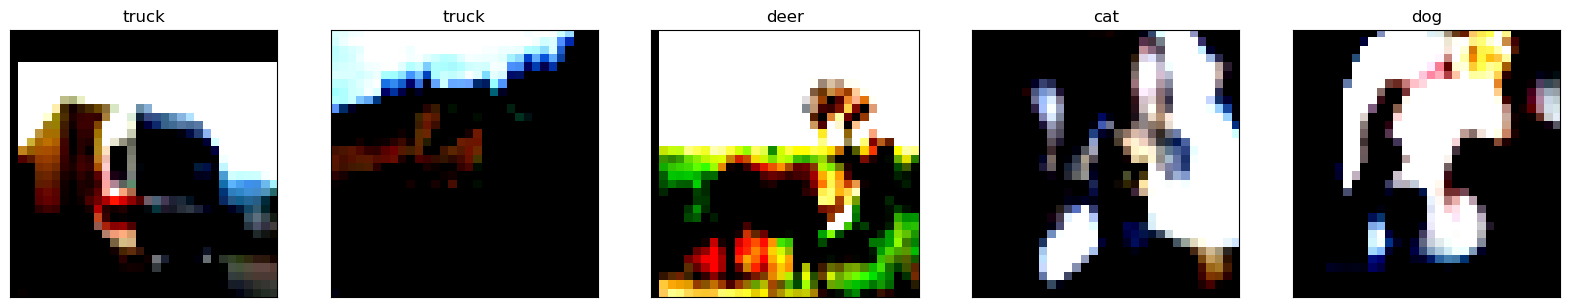

In [5]:
# check the structure of data loader 
for images, labels in train_loader :
    print('image batch dimensions : ', images.shape)
    print('image label dimensions : ', labels.shape)
    break

num_classes = 10
class_names = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

# visualize the random 5 datas, labels
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    

In [6]:
class BuildingBlock(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = 1      # In block without down_sampling, stride is 1.
        self.kernel_size = 3 # In block without down_sampling, kernel_size is 3.
        self.padding = 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x) : 
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out) 
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity # identity mapping
        out = self.relu2(out)
        
        return out

In [7]:
class BuildingBlockWithDownSample(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = 3
        self.down_sampling_kernel_size = 1
        self.conv1_stride = 2 # In block with down_sampling, conv1's stride is 2.
        self.conv2_stride = 1 # In block with down_sampling, conv2's stride is 1.
        self.padding = 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv1_stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv2_stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        # (projection shortcut) : H, W of activation map are down_sampled, C of activation map is up_sampled
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.down_sampling_kernel_size, stride=self.conv1_stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        )
    
    def forward(self, x) : 
        identity = self.downsample(x) # projection shortcut 
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity       # projection shortcut
        out = self.relu2(out) # block output
        
        return out
        
        

In [8]:
# Class ResNet32 > Class BuildingBlock, Class BuildingBlockWithDownSample
class MyResNet32(nn.Module) :
    def __init__(self) :
        super().__init__()
        num_classes : int = 10
        
        # 3 x 32 x 32 -> 16 x 32 x 32
        self.layer0 = nn.Sequential( # 5 * 2 + 1 = 11
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
                                    
            BuildingBlock(16, 16), # identity mapping
            BuildingBlock(16, 16), # identity mapping
            BuildingBlock(16, 16), # identity mapping
            BuildingBlock(16, 16), # identity mapping
            BuildingBlock(16, 16), # identity mapping
        )
        # 16 x 32 x 32 -> 32 x 16 x 16
        self.layer1 = nn.Sequential( # 5 * 2 = 10
            BuildingBlockWithDownSample(16, 32), # projection shortcut
            BuildingBlock(32, 32), # identity mapping
            BuildingBlock(32, 32), # identity mapping
            BuildingBlock(32, 32), # identity mapping
            BuildingBlock(32, 32), # identity mapping
        )
        # 32 x 16 x 16 -> 64 x 8 x 8
        self.layer2 = nn.Sequential( # 5 * 2 + 1= 11
            BuildingBlockWithDownSample(32, 64), # projection shortcut
            BuildingBlock(64, 64), # identity mapping
            BuildingBlock(64, 64), # identity mapping
            BuildingBlock(64, 64), # identity mapping
            BuildingBlock(64, 64), # identity mapping
            
            # global average pooling
            nn.AdaptiveAvgPool2d((1, 1)),
            # fully connected layer
            nn.Flatten(),
            nn.Linear(64, num_classes, bias=True)
        )
        
    def forward(self, x) : 
        ## 3 x 32 x 32 -> 16 x 32 x 32
        x = self.layer0(x)
        ## 16 x 32 x 32 -> 32 x 16 x 16
        x = self.layer1(x)
        ## 32 x 16 x 16 -> 64 x 8 x 8 -> 64 x 1 x 1
        x = self.layer2(x)
        
        return x        
        

In [9]:
# training details
## randomly sample 224×224 crops for data augmentation.
## We use a mini-batch size of 256 images for fine-tuning
## The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
## We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
## We initialize the learning rate for the pre-trained network to be 0.01
model = MyResNet32()
print(model.eval)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# he initialization, not use bias
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.fill_(1)

model.apply(init_weights)

<bound method Module.eval of MyResNet32(
  (layer0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): BuildingBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (4): BuildingBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Con

MyResNet32(
  (layer0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): BuildingBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (4): BuildingBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3

In [10]:
writer = SummaryWriter('../runs/my_resnet32_exp2')

# record model to tensorboard
# Assuming 'device' is defined as torch.device("cuda") or "cuda:0"
input_tensor = trainset[0][0].unsqueeze(0).to(device)
writer.add_graph(model, input_tensor)

In [11]:
# hyper parameters
## learning rate
lr = 0.1
## momentum
momentum = 0.9
## weight decay
L2 = 0.0001
# the number of iterations at 1 epoch
num_iters = (len(trainset) // mini_batch_size) + 1
print(f"num_iters at 1 epoch: {num_iters}")

epochs = 64000 // mini_batch_size
# 32k, 48k iter = ?, ? epochs
print(f"34k iteration : {32000 // mini_batch_size} epochs")
print(f"48k iteration : {48000 // mini_batch_size} epochs")
print(f"64k iteration : {epochs} epochs")

## optimizer
## scheduler
## loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=L2)        

# 125 epoch, 187 epoch lr decay
lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[125, 187], gamma=0.1)

num_iters at 1 epoch: 196
34k iteration : 125 epochs
48k iteration : 187 epochs
64k iteration : 250 epochs


In [12]:
# check # of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"# of total parameters : {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"# of trainable parameters : {total_trainable_params}")

# of total parameters : 466906
# of trainable parameters : 466906


In [13]:

val_loss_list = []
val_acc_list = []

In [14]:
import time
# Start measuring time
start_time = time.time()

# ------------------------------------------------------------------------------------------------------------------------------

# training no pretrained resnet34 model with GPU
for epoch in range(0, epochs):
            
    model.train().to(device)
    running_loss = 0.0
    print(f"{epoch+1} / {epochs} epoch ----------------------------------------")
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # every 50 iteration
        running_loss += loss.item()
        if i % 50 == 49:
            print(f"[{epoch+1}, {i+1}th iteration] loss : {running_loss / 50}")
            writer.add_scalar('training loss', running_loss / 50, epoch * num_iters + i)
            running_loss = 0.0
            
    # every epoch
    # validation loss, accuracy
    val_loss = 0.0
    correct = 0
    total = 0
    model.eval().to(device)
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print(f"val loss : {val_loss / num_val_batch}")
    print(f"val acc : {100. * correct / total}")
    writer.add_scalar('validation loss', val_loss / num_val_batch, epoch+1)
    writer.add_scalar('validation acc', 100. * correct / total, epoch+1)
    writer.flush()
    lr_scheduler.step()
    writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch+1)
    val_loss_list.append(val_loss / num_val_batch)
    val_acc_list.append(100. * correct / total)
            
    # odd epoch, save model
    if (epoch+1) % 5 == 1:
        PATH = f"./My_ResNet32_exp2_checkpoint/epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), PATH)
        # save best model (minimum val loss)
        if val_loss / num_val_batch == min(val_loss_list):
            PATH = f"./My_ResNet32_exp2_checkpoint/best_model.pth"
            torch.save(model.state_dict(), PATH)
    
    
# ------------------------------------------------------------------------------- -----------------------------------------------        
        
# End measuring time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

1 / 250 epoch ----------------------------------------


[1, 50th iteration] loss : 2.211972270011902
[1, 100th iteration] loss : 1.7540726995468139
[1, 150th iteration] loss : 1.6101276803016662
val loss : 1.7717203727135291
val acc : 39.72
2 / 250 epoch ----------------------------------------
[2, 50th iteration] loss : 1.4083080053329469
[2, 100th iteration] loss : 1.3186239337921142
[2, 150th iteration] loss : 1.2413698387145997
val loss : 1.2378769532228127
val acc : 57.26
3 / 250 epoch ----------------------------------------
[3, 50th iteration] loss : 1.0932189524173737
[3, 100th iteration] loss : 1.0480859351158143
[3, 150th iteration] loss : 0.9965942478179932
val loss : 1.2561485125468328
val acc : 59.97
4 / 250 epoch ----------------------------------------
[4, 50th iteration] loss : 0.9156190729141236
[4, 100th iteration] loss : 0.8788312411308289
[4, 150th iteration] loss : 0.8272207295894622
val loss : 1.2893127630918453
val acc : 61.06
5 / 250 epoch ----------------------------------------
[5, 50th iteration] loss : 0.80199221

In [15]:
# val loss, accuracy
val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}")


val loss : 0.42420675242558503
val acc : 92.14


In [17]:
# epoch 216 model
PATH = f"./My_ResNet32_exp2_checkpoint/epoch_216.pth"
model.load_state_dict(torch.load(PATH))

# val loss, accuracy
val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"val error rate : {100. * (total - correct) / total}%")

val loss : 0.4208787523019008
val acc : 92.27%
val error rate : 7.73%


: 